In [3]:
!pip install -q git+https://github.com/huggingface/transformers datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 290 kB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 41.8 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
     |████████████████████████████████| 895 kB 44.0 MB/s 
     |████████████████████████████████| 596 kB 37.5 MB/s 
     |████████████████████████████████| 1.1 MB 45.6 MB/s 
     |████████████████████████████████| 243 kB 50.5 MB/s 
     |████████████████████████████████| 132 kB 49.8 MB/s 
     |████████████████████████████████| 160 kB 45.7 MB/s 
     |████████████████████████████████| 271 kB 44.8 MB/s 
     |████████████████████████████████| 192 kB 43.9 MB/s 


In [4]:
from datasets import *
from transformers import ViTFeatureExtractor
from transformers import ViTModel
from transformers import TrainingArguments, Trainer
from transformers.modeling_outputs import SequenceClassifierOutput
import numpy as np
import pandas as pd 
import torch.nn as nn
import pickle
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

## Preprocessing



FER-2013 dataset consists of 35.887 48x48 pixel grayscale images representing 7 different emotions.
It is preprocessed using `ViTFeatureExtractor`, which resizes every image to the resolution that the model expects, i.e. 224x224, and normalizes the channels.

FER2013: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

FER2013 Paper: https://arxiv.org/pdf/1307.0414.pdf



In [5]:
string_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

In [6]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Load original data into a DataFrame

In [13]:
fer_df = pd.read_csv("drive/MyDrive/FYP/fer2013/sampled2013.csv")  # available on kaggle

In [14]:
fer_df.head()

,emotion,pixels,Usage
0,6,113 117 117 116 111 108 107 109 124 125 90 65 ...,Training
1,2,252 251 255 175 110 84 22 27 36 37 25 36 38 36...,Training
2,6,182 182 181 180 180 180 180 180 180 179 152 85...,Training
3,6,46 47 80 86 47 49 43 58 37 20 12 4 3 2 2 3 3 3...,Training
4,5,238 238 238 238 239 232 202 150 140 171 156 13...,Training


First preprocessing step

In [15]:
def prepare_fer_data(data):
    """ Prepare fer data for vision transformer 
        input: fer df loaded from csv
        output: df that can be load into a huggingface dataset """

    # outputs
    image_list = []
    image_labels = list(map(int, data['emotion']))
    
    # go over all images
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        # adapt grayscale to rgb format (change single values to triplets of the same value)
        image = image[..., np.newaxis]
        image = np.repeat(image, 3, axis=2)
        # convert to list format used by the later functions
        image = image.astype(int).tolist()
        # save to output
        image_list.append(image)

    output_df = pd.DataFrame(list(zip(image_list, image_labels)),
               columns =['img', 'label'])
        
    return output_df

In [16]:
fer_train_df = prepare_fer_data(fer_df[fer_df['Usage']=='Training'])
fer_test_df = prepare_fer_data(fer_df[fer_df['Usage']=='PrivateTest'])
fer_val_df = prepare_fer_data(fer_df[fer_df['Usage']=='PublicTest'])

In [17]:
fer_train_df.head()

,img,label
0,"[[[113, 113, 113], [117, 117, 117], [117, 117,...",6
1,"[[[252, 252, 252], [251, 251, 251], [255, 255,...",2
2,"[[[182, 182, 182], [182, 182, 182], [181, 181,...",6
3,"[[[46, 46, 46], [47, 47, 47], [80, 80, 80], [8...",6
4,"[[[238, 238, 238], [238, 238, 238], [238, 238,...",5


In [18]:
print(len(fer_train_df))#random sampled, 20% of the training set
print(len(fer_test_df))#random sampled, 20% of the test set
print(len(fer_val_df))#random sampled, 20% of the validation set

5742
718
718


In [19]:
train_ds = Dataset.from_pandas(fer_train_df)
# undersample train due to memory issues on google colab
splits = train_ds.train_test_split(test_size=0.3)
train_ds = splits["train"]

val_ds = Dataset.from_pandas(fer_val_df)
test_ds = Dataset.from_pandas(fer_test_df)

train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 4019
})

In [20]:
# image size 
np.array(train_ds[0]["img"]).shape

(48, 48, 3)

Second preprocessing step using the ViT feature extractor

In [21]:
def preprocess_images(examples):
    """ Prepare datasets for vision transformer 
    input: dataset with images in their orignal size 
    output: dataset with pixelvalues computed by the feature extractor added """
    # get batch of images
    images = examples['img']
    # convert to list of NumPy arrays of shape (C, H, W)
    images = [np.array(image, dtype=np.uint8) for image in images]
    images = [np.moveaxis(image, source=-1, destination=0) for image in images]
    # preprocess and add pixel_values
    inputs = feature_extractor(images=images)
    examples['pixel_values'] = inputs['pixel_values']

    return examples

In [22]:
# features of the new dataset with an additional column for the preprocess 224x224x3 images 
features = Features({
    'label': ClassLabel(names=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']),
    'img': Array3D(dtype="int64", shape=(3,48,48)),
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
})

preprocessed_train_ds = train_ds.map(preprocess_images, batched=True, features=features)#batch_size=1, 

preprocessed_val_ds = val_ds.map(preprocess_images, batched=True, features=features)

preprocessed_test_ds = test_ds.map(preprocess_images, batched=True, features=features)

preprocessed_train_ds


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['label', 'img', 'pixel_values'],
    num_rows: 4019
})

In [23]:
# final image size
print(len(preprocessed_train_ds[0]["pixel_values"]))       
print(len(preprocessed_train_ds[0]["pixel_values"][0]))     
print(len(preprocessed_train_ds[0]["pixel_values"][0][0])) 

3
224
224


## Looking at the Data 
Let's quickly look at some samples of processed data as well as the label distribution.

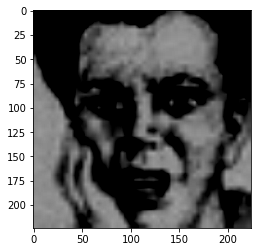

Surprise


In [24]:
# show a single image from the dataset
data_for_image = np.array(preprocessed_train_ds[0]["pixel_values"])
data_for_image[data_for_image < 0] = 0 

plt.imshow(np.transpose(data_for_image, (1,2,0)), interpolation='nearest')
plt.show()

print(string_labels[preprocessed_train_ds[0]["label"]])

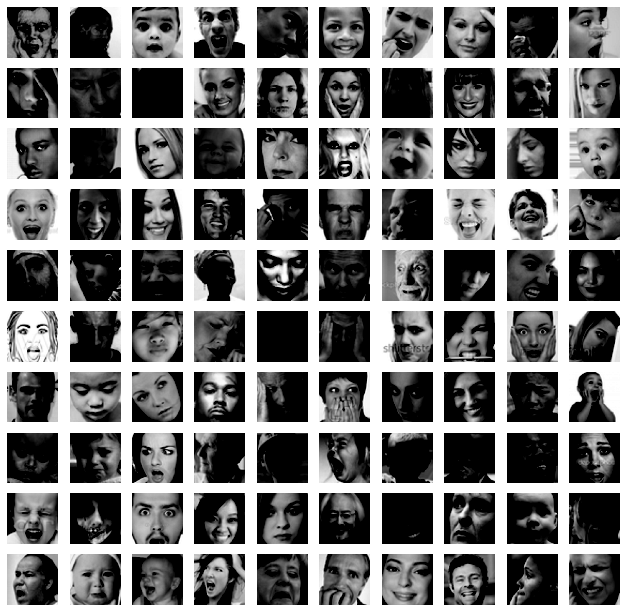

In [25]:
# show 100 images from the dataset
fig, axes = plt.subplots(10,10, figsize=(11,11))
for i,ax in enumerate(axes.flat):
  data_for_image = np.array(preprocessed_train_ds[i]["pixel_values"])
  data_for_image[data_for_image < 0] = 0 
  ax.imshow(np.transpose(data_for_image, (1,2,0)), interpolation='nearest')
  ax.set_axis_off()


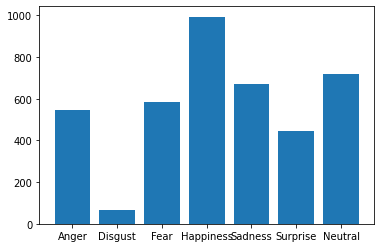

In [26]:
# distribution of labels in the training set
keys, counts = np.unique(preprocessed_train_ds["label"], return_counts=True)
plt.bar(string_labels, counts)
plt.show()

## Defining the model

The model architecture is defined in PyTorch, with dropout and a linear layer added on top of the ViT model's output of the special CLS token representing the input picture. 


In [27]:
class ViTForImageClassification(nn.Module):
    #define architecture
    def __init__(self, num_labels=len(string_labels)):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    #define a forward pass through that architecture + loss computation
    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

Training uses the standard HuggingFace [Trainer](https://huggingface.co/transformers/main_classes/trainer.html) interface. 

In [28]:
metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    evaluation_strategy = "epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,#on colab
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
)

In [29]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

In [30]:
model = ViTForImageClassification()

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

In [31]:
trainer = Trainer(
    model = model,
    args = args,
    train_dataset = preprocessed_train_ds,
    eval_dataset = preprocessed_val_ds,
    compute_metrics = compute_metrics,
)

## Fine-tuning ViT


Fine-tuning the model by calling the `train()` method

In [32]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: img.
***** Running training *****
  Num examples = 4019
  Num Epochs = 6
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1512


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.247670,0.590529
2,1.338300,1.137396,0.594708
3,1.338300,1.072918,0.637883
4,0.874600,1.061623,0.635097
5,0.874600,1.044975,0.633705
6,0.638800,1.046000,0.636490


The following columns in the evaluation set  don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: img.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 16
Saving model checkpoint to test-cifar-10/checkpoint-252
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
The following columns in the evaluation set  don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: img.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 16
Saving model checkpoint to test-cifar-10/checkpoint-504
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
The following columns in the evaluation set  don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: img.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 16
Saving model checkpoint to test-cifar-10/checkpoint-756
Trainer.model is not a `PreTrainedMode

TrainOutput(global_step=1512, training_loss=0.9474665743333323, metrics={'train_runtime': 2188.1642, 'train_samples_per_second': 11.02, 'train_steps_per_second': 0.691, 'total_flos': 0.0, 'train_loss': 0.9474665743333323, 'epoch': 6.0})

## Evaluation on Test Set

The test score after fine-tuning

In [33]:
outputs = trainer.predict(preprocessed_test_ds)
print(outputs.metrics)

The following columns in the test set  don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: img.
***** Running Prediction *****
  Num examples = 718
  Batch size = 16


{'test_loss': 1.0551042556762695, 'test_accuracy': 0.6114206128133705, 'test_runtime': 25.3341, 'test_samples_per_second': 28.341, 'test_steps_per_second': 1.776}


The results on the test set as confusion matrix

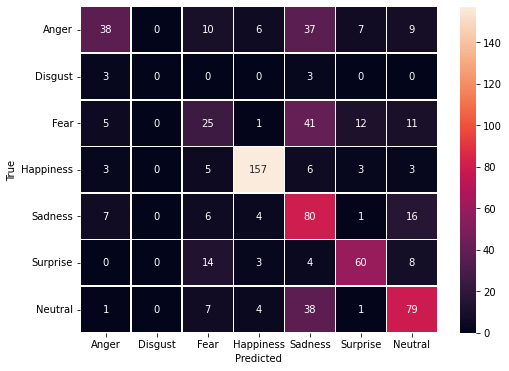

In [34]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

cm = confusion_matrix(y_true, y_pred)

# plot with seaborn
fig, ax = plt.subplots(figsize=(8,6))  
ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, xticklabels=string_labels, yticklabels=string_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()